In [1]:
import os
import sys
import rootpath
sys.path.append(rootpath.detect())

from pymoo.factory import get_performance_indicator
from testsuite.utilities import Pareto_split, get_target_igd_refpoints
from testsuite.analysis import load_all #, plot_all_pareto_2d, PLOT_STYLE, plot_measure
from problem_setup import func, y, weighting, n_obj, n_dim

import pickle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from testsuite import directed_optimisers 
from pymoo.factory import get_performance_indicator
from scipy.spatial import distance_matrix
from scipy.spatial.distance import cdist
import inspect

In [3]:
from generate_queue import targets

In [4]:
def get_target_from_str(string):
    ind = string.find('[')
    tstring = string[ind+1:-1]
    for target in targets:
        str_t = str(target).replace('.', 'p').replace(' ', '_')
        if tstring == str_t:
            return target

In [5]:
def load_result(directory):
    result = load_all(directory, trailing_text = "_results.pkl")
    name = get_name_from_dir(directory)
    result['name'] = name
    return result

def get_name_from_dir(dir_string):
    bits = dir_string.split('_')
    name = [bit for bit in bits if bit.lower() in OPTIMISER_NAMES]

    if type(name) is list:
        name = name[0]
    if 'ei' in bits:
        name+='_ei'
    elif 'mean' in bits:
        name+='_$\mu$'
    return name

In [6]:
names = ['Mpoi', 'ParEgo', 'Saf_ei', 'Saf_$\\mu$', 'SmsEgo_ei', 'SmsEgo_$\\mu$', 'lhs']
true_names = ['MPoI', 'ParEGO', 'SAF: ei', 'SAF: $\mu$', 'SMS-EGO: ei', 'SMS-EGO: $\mu$', 'LHS']
D_names = {a:b for a, b in zip(names, true_names)}

In [7]:
OPTIMISER_NAMES = [cls[0].lower() for cls in inspect.getmembers(directed_optimisers, inspect.isclass)
        if cls[1].__module__ == 'testsuite.directed_optimisers' or cls[1].__module__ == 'testsuite.optimisers']

In [8]:
OPTIMISER_NAMES

['directedsaf', 'saf']

In [9]:
problem_path = './'

In [10]:
# load all results from directory tree
result_dirs = sorted(os.listdir(os.path.join(problem_path, "log_data/")))
results= []
for path in result_dirs:
    result = load_result(os.path.join(problem_path, 'log_data/',  path))
    results.append(result)
result_dirs

['WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[0p459_3p303_1p647]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[0p51_3p67_1p83]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[0p561_4p037_2p013]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p557_1p467_1p548]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p73_1p63_1p72]]',
 'WFG4_DirectedSaf_init10_MultiSurrogate_GP_mean_mean_target[[1p903_1p793_1p892]]']

In [11]:
p = np.load('../../../comp/igd_refpoints/problem_refpoints/data/wfg_elipse_3d_refpoints')
p.shape

(11958, 3)

In [12]:
# load all results from directory tree
result_dirs2 = ['/home/finley/phd/code/testsuite/experiments/comp/data/wfg4_3obj_8dim/log_data/WFG4_Saf_init10_MultiSurrogate_mean/']
undirected_results= []
for path in result_dirs2:
    result = load_result(os.path.join(problem_path, 'log_data/',  path))
    undirected_results.append(result)

11640 319
Target:  [1.557 1.467 1.548]


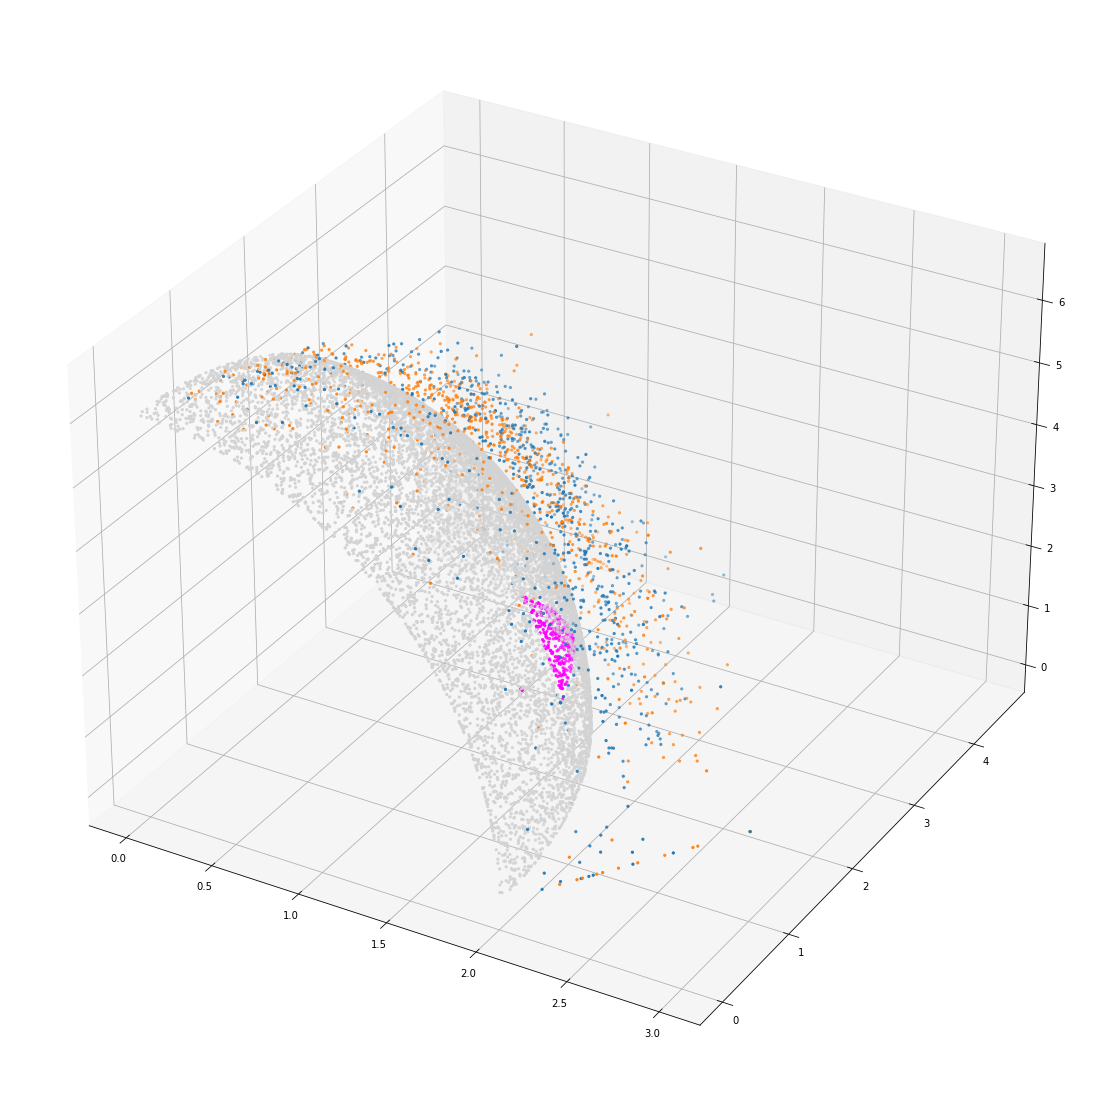

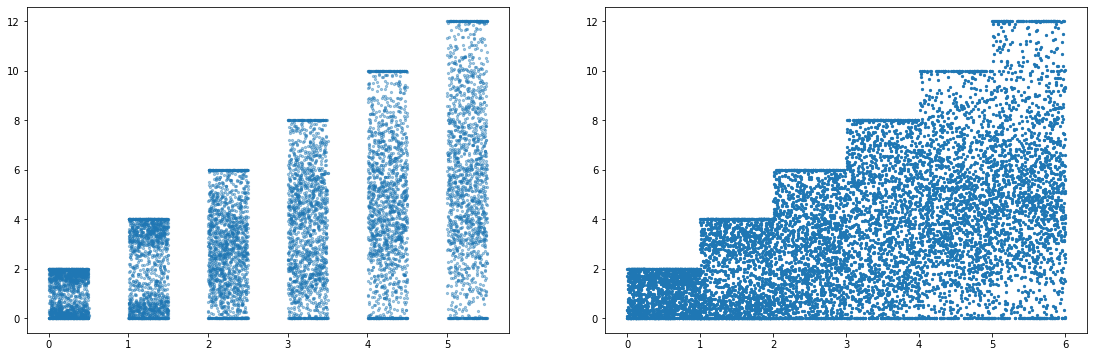

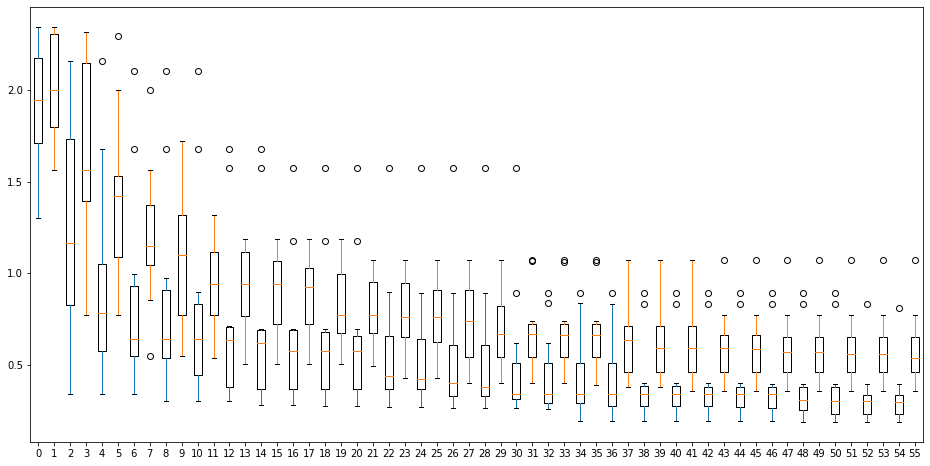

In [13]:
t_num = 3
stage=150
target = get_target_from_str(results[t_num]['log_dir'][0])
pt, pd = get_target_igd_refpoints(target, p)
print('Target: ', target)

fig0 = plt.figure(figsize=[20, 20])
fig0_ax = fig0.gca(projection='3d')
for i in range(11):
    pp, dd = Pareto_split(results[t_num]['y'][i][:stage])
    fig0_ax.scatter(*pp.T, c="C0", s=5)
    
for i in range(11):
    pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage])
    fig0_ax.scatter(*pp.T, c="C1", s=5)
fig0_ax.scatter(*pd.T, c="lightgrey", s=5)
fig0_ax.scatter(*pt.T, c="magenta", s=5)
fig0_ax.scatter(*target.T, c="magenta")
# fig0_ax.axis('scaled')

fig1 = plt.figure(figsize=[19, 6])
fig1_ax0 = fig1.add_subplot(121)
fig1_ax1 = fig1.add_subplot(122)
for i in range(11):
    pp, dd = Pareto_split(results[t_num]['y'][i][:stage], return_indices=True)
    xs = results[0]['x'][i][:stage]
    for j in range(6):
        fig1_ax0.scatter(np.ones(stage)*j+np.random.rand(stage)*0.5, xs[:,j], c="C0", s=5, alpha=0.4)

for i in range(11):
    pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage], return_indices=True)
    xs = undirected_results[0]['x'][i][:stage]
    for j in range(6):
        fig1_ax1.scatter(np.ones(stage)*j+np.random.rand(stage)*10e-1, xs[:,j], c="C0", s=5)

igdp_measure = get_performance_indicator("igd+", pt)

stage_directed = []
stage_undirected = []
for stage in range(10, 150, 5):
    igdps_directed = []
    igdps_undirected = []
    for i in range(11):
        pp, dd = Pareto_split(results[t_num]['y'][i][:stage])
        igdp_directed = igdp_measure.calc(pp)
        pp, dd = Pareto_split(undirected_results[0]['y'][i][:stage])
        igdp_undirected = igdp_measure.calc(pp)
        igdps_directed.append(igdp_directed)
        igdps_undirected.append(igdp_undirected)
    stage_directed.append(igdps_directed)
    stage_undirected.append(igdps_undirected)

fig2 = plt.figure(figsize=[16, 8])
fig2_ax = fig2.gca()
fig2_ax.boxplot(stage_directed, positions=list(range(56))[::2], whiskerprops=dict(color="C0"));
fig2_ax.boxplot(stage_undirected, positions=list(range(56))[1::2], whiskerprops=dict(color="C1"));